# Эмбеддинги на все случаи жизни

**Эмбеддинг** — это массив чисел, который получается преобразованием какого‑то объекта (в нашем случае - текста).

![IMG](https://habrastorage.org/r/w1560/getpro/habr/upload_files/6bf/e1a/f1e/6bfe1af1ea721e22deb5cd4fef06cca5.png)

Мы уже знаем, что такое эмбеддинги и даже сталкивались с ними! *Вспомните 12-ый семинар про векторыне представления слов*

## Глава 0: Подготовка данных

In [ ]:
# Установка необходимых библиотек
!pip install -q sentence-transformers datasets

In [ ]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('default')
pd.set_option('display.max_colwidth', 100)

Сегодня мы будем работать с [датасетом](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) новостных заголовков, где нужно определить, является ли заголовок саркастичным или нет.

Почему детекция сарказма сложная задача?

- Сарказм часто зависит от контекста
- Одни и те же слова могут быть саркастичными или нет
- Требуется понимание тонких нюансов языка

### Загрузка датасета

In [ ]:
from datasets import load_dataset

dataset = load_dataset("raquiba/Sarcasm_News_Headline")

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"\nСтруктура данных:\n")
train_data.head()

Размер обучающей выборки: 28619
Размер тестовой выборки: 26709

Структура данных:



,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clock of hair loss,https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html
3,1,inclement weather prevents liar from getting to work,https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031
4,1,mother comes pretty close to using word 'streaming' correctly,https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546


> Что вы видете в датасете? Как вам размеры обучающей/тестовой выборок?

### Анализ датасета

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  26709 non-null  int64 
 1   headline      26709 non-null  object
 2   article_link  26709 non-null  object
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
train_data.duplicated().sum()

np.int64(2)

In [ ]:
test_data.duplicated().sum()

np.int64(1)

> Ура! Дубликаты!! Как их удалить?)

In [ ]:
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

Первично с данными разобрались. Посмотрим теперь, как распределены классы.

Это можно сделать вот так...

In [ ]:
class_distribution = train_data['is_sarcastic'].value_counts()
class_distribution

,count
is_sarcastic,
0,14984
1,13633


Или ✨вот так✨

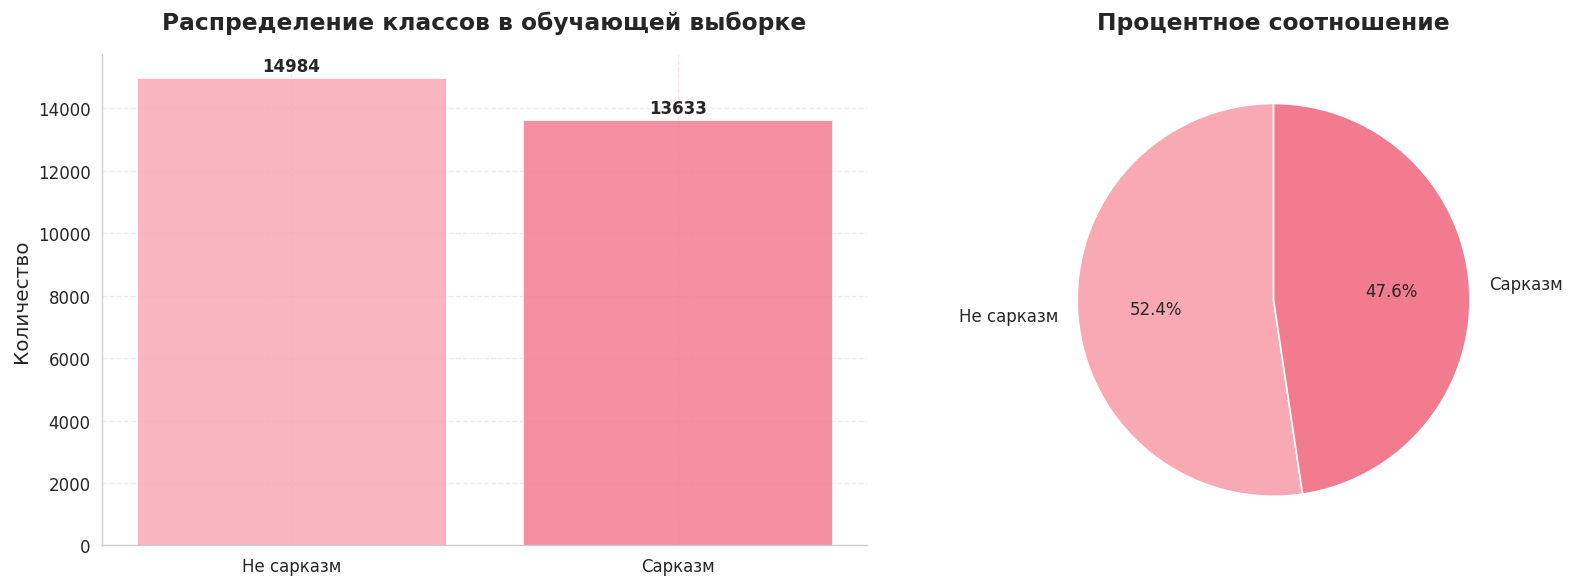


Доля саркастичных заголовков: 47.64%
Доля обычных заголовков: 52.36%


In [ ]:
sns.set_style("whitegrid")
pink_palette = ["#f8a9b3", "#f27b8f", "#ee5a7a", "#e73a63", "#d41c5b"]
sns.set_palette(sns.color_palette(pink_palette))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# Plot 1: Class Distribution Bar Chart
bars = axes[0].bar(['Не сарказм', 'Сарказм'], class_distribution.values,
                  color=["#f8a9b3", "#f27b8f"], edgecolor='white', linewidth=0.5, alpha=0.85)

axes[0].set_ylabel('Количество', fontsize=12, fontweight='medium')
axes[0].set_title('Распределение классов в обучающей выборке',
                 fontsize=14, fontweight='bold', pad=15)

# Add value labels on bars
for i, v in enumerate(class_distribution.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom',
                fontweight='bold', fontsize=10)

# Styling for bar chart
axes[0].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Pie Chart
wedges, texts, autotexts = axes[1].pie(class_distribution.values,
                                      labels=['Не сарказм', 'Сарказм'],
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=["#f8a9b3", "#f27b8f"],
                                      textprops={'fontsize': 10, 'fontweight': 'medium'})

axes[1].set_title('Процентное соотношение',
                 fontsize=14, fontweight='bold', pad=15)

# Style adjustments for pie chart text
for text in texts + autotexts:
    text.set_fontweight('medium')

plt.tight_layout()
plt.show()

print(f"\nДоля саркастичных заголовков: {class_distribution[1] / len(train_data) * 100:.2f}%")
print(f"Доля обычных заголовков: {class_distribution[0] / len(train_data) * 100:.2f}%")

> Какие выводы вы можете сделать?

> Есть ли дисбаланс классов?

Давайте посмотрим на конкретные примеры из датасета

In [ ]:
print("=" * 80)
print("ПРИМЕРЫ САРКАСТИЧНЫХ ЗАГОЛОВКОВ:")
print("=" * 80)
sarcastic_examples = train_data[train_data['is_sarcastic'] == 1].sample(5, random_state=42)
for idx, row in sarcastic_examples.iterrows():
    print(f"📰 {row['headline']}")
    print()

ПРИМЕРЫ САРКАСТИЧНЫХ ЗАГОЛОВКОВ:
📰 male friends depart for annual camping trip to complain about camping

📰 everything reminds man of 'her'

📰 longtime sexual fantasy awkwardly fulfilled

📰 'back to dock' voted most popular destination among current rowboat passengers

📰 kasich trying to find other states where he is beloved multi-term governor



In [ ]:
print("=" * 80)
print("ПРИМЕРЫ ОБЫЧНЫХ ЗАГОЛОВКОВ:")
print("=" * 80)
normal_examples = train_data[train_data['is_sarcastic'] == 0].sample(5, random_state=42)
for idx, row in normal_examples.iterrows():
    print(f"📰 {row['headline']}")
    print()

ПРИМЕРЫ ОБЫЧНЫХ ЗАГОЛОВКОВ:
📰 mars and venus in mental health

📰 what's leaving netflix in may 2016?

📰 dogs in asia: doctors not dinner

📰 rand's filibuster two-fer

📰 divorcing parents: 10 questions to ask before fighting over the kids



> Что вы можете сказать о разметке? Согласны ли вы с ней в представленных примерах? Разметка субъективна или нет?

> Что вы можеет сказать о самих данных? Как выглядят заголовки? Требуют ли они предобработки?

Давайте дополнительно проанализируем длины заголовков по каждому классу!)


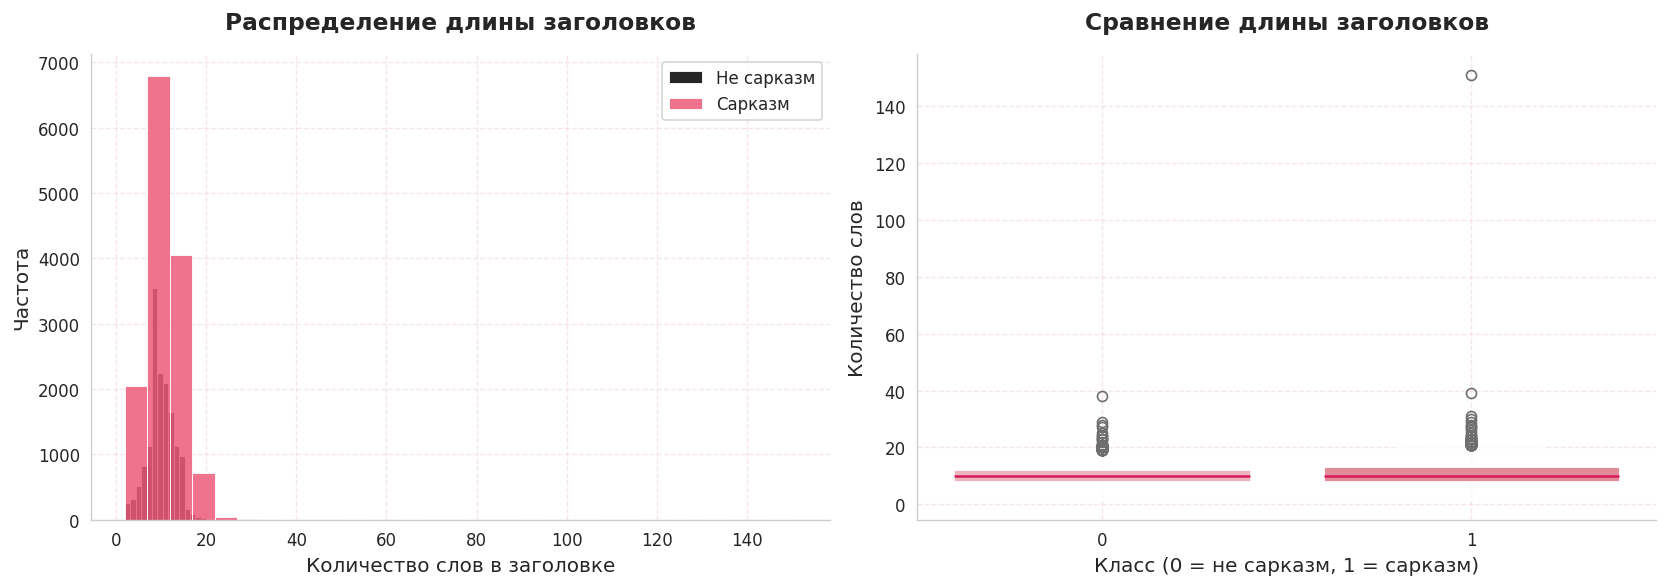


Статистика по длине заголовков:
                count       mean       std  min  25%   50%   75%    max
is_sarcastic                                                           
0             14984.0   9.816004  2.885750  2.0  8.0  10.0  12.0   38.0
1             13633.0  10.307489  3.849606  2.0  8.0  10.0  13.0  151.0


In [ ]:
sns.set_style("whitegrid")
pink_palette = ["#f8a9b3", "#f27b8f", "#ee5a7a", "#e73a63", "#d41c5b"]
sns.set_palette(sns.color_palette(pink_palette))

train_data['headline_length'] = train_data['headline'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# Plot 1: Distribution of headline lengths
sns.histplot(train_data[train_data['is_sarcastic'] == 0]['headline_length'],
             bins=30, alpha=0.85, label='Не сарказм', color="#0000",
             edgecolor='white', linewidth=0.5, ax=axes[0])
sns.histplot(train_data[train_data['is_sarcastic'] == 1]['headline_length'],
             bins=30, alpha=0.85, label='Сарказм', color="#ee5a7a",
             edgecolor='white', linewidth=0.5, ax=axes[0])

axes[0].set_xlabel('Количество слов в заголовке', fontsize=12, fontweight='medium')
axes[0].set_ylabel('Частота', fontsize=12, fontweight='medium')
axes[0].set_title('Распределение длины заголовков', fontsize=14, fontweight='bold', pad=15)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Boxplot comparison
sns.boxplot(x='is_sarcastic', y='headline_length', data=train_data,
            palette=["#f8a9b3", "#f27b8f"], ax=axes[1],
            boxprops=dict(edgecolor='white', linewidth=0.5),
            whiskerprops=dict(color='white', linewidth=0.5),
            capprops=dict(color='white', linewidth=0.5),
            medianprops=dict(color='#d41c5b', linewidth=1.5))

axes[1].set_xlabel('Класс (0 = не сарказм, 1 = сарказм)', fontsize=12, fontweight='medium')
axes[1].set_ylabel('Количество слов', fontsize=12, fontweight='medium')
axes[1].set_title('Сравнение длины заголовков', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nСтатистика по длине заголовков:")
print(train_data.groupby('is_sarcastic')['headline_length'].describe())

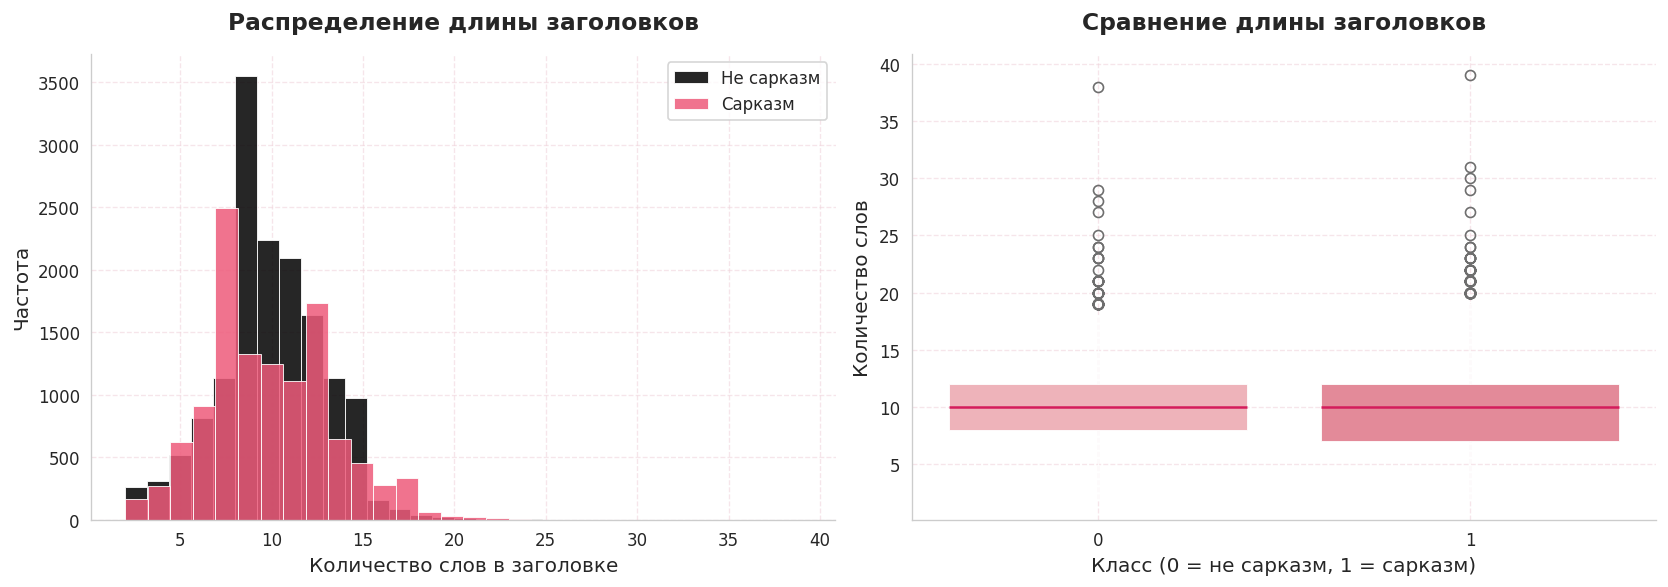


Статистика по длине заголовков:
                count      mean       std  min  25%   50%   75%   max
is_sarcastic                                                         
0             14984.0  9.816004  2.885750  2.0  8.0  10.0  12.0  38.0
1             11724.0  9.884425  3.497143  2.0  7.0  10.0  12.0  39.0


In [ ]:
sns.set_style("whitegrid")
pink_palette = ["#f8a9b3", "#f27b8f", "#ee5a7a", "#e73a63", "#d41c5b"]
sns.set_palette(sns.color_palette(pink_palette))

test_data['headline_length'] = test_data['headline'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# Plot 1: Distribution of headline lengths
sns.histplot(test_data[test_data['is_sarcastic'] == 0]['headline_length'],
             bins=30, alpha=0.85, label='Не сарказм', color="#0000",
             edgecolor='white', linewidth=0.5, ax=axes[0])
sns.histplot(test_data[test_data['is_sarcastic'] == 1]['headline_length'],
             bins=30, alpha=0.85, label='Сарказм', color="#ee5a7a",
             edgecolor='white', linewidth=0.5, ax=axes[0])

axes[0].set_xlabel('Количество слов в заголовке', fontsize=12, fontweight='medium')
axes[0].set_ylabel('Частота', fontsize=12, fontweight='medium')
axes[0].set_title('Распределение длины заголовков', fontsize=14, fontweight='bold', pad=15)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Boxplot comparison
sns.boxplot(x='is_sarcastic', y='headline_length', data=test_data,
            palette=["#f8a9b3", "#f27b8f"], ax=axes[1],
            boxprops=dict(edgecolor='white', linewidth=0.5),
            whiskerprops=dict(color='white', linewidth=0.5),
            capprops=dict(color='white', linewidth=0.5),
            medianprops=dict(color='#d41c5b', linewidth=1.5))

axes[1].set_xlabel('Класс (0 = не сарказм, 1 = сарказм)', fontsize=12, fontweight='medium')
axes[1].set_ylabel('Количество слов', fontsize=12, fontweight='medium')
axes[1].set_title('Сравнение длины заголовков', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nСтатистика по длине заголовков:")
print(test_data.groupby('is_sarcastic')['headline_length'].describe())

> Что вы можете сказать про распределение? *Смотрите не только на графики!*

> Сравните распределение на тестовом и обучающем наборе данных. Что вы видите?

Избавимся от выбросов и продолжим!

In [ ]:
train_data_filtered = train_data[(train_data['headline_length'] >= 7) & (train_data['headline_length'] <= 13)]
test_data_filtered = test_data[(test_data['headline_length'] >= 7) & (test_data['headline_length'] <= 13)]

print(f"Размер обучающего датасета после фильтрации: {len(train_data_filtered)}")

Размер обучающего датасета после фильтрации: 20721


In [ ]:
train_data_filtered['is_sarcastic'].value_counts()

,count
is_sarcastic,
0,11783
1,8938


In [ ]:
test_data_filtered['is_sarcastic'].value_counts()

,count
is_sarcastic,
0,11783
1,7909


Мы применим **undersampling**! Для этого мы воспользуемся модулем `RandomUnderSampler` изи библиотеки `imblearn`. Код будет выглядеть так:

```python
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
```

К сожалению, нельзя применить андерсемплинг к текстовым данным, которые являются одномерным массивом. Методы андерсемплинга работают с числовыми двумерными признаками. Поэтому заниматься этим мы будем на этапе векторизации.

## Глава 1: Повторение

Мы уже изучали различные методы векторизации текстов: **Bag of Words (BOW), TF-IDF и Word2Vec**. Давайте быстро вспомним основные концепции.

**Векторизация** — это процесс преобразования текста в числовые векторы, с которыми может работать машинное обучение.
Основные методы:

- **BOW**: простой подсчет частоты слов
- **TF-IDF**: взвешенная частота (редкие слова важнее)
- **Word2Vec**: семантические векторы слов

Сегодня мы пойдем дальше и изучим контекстуальные эмбеддинги, которые понимают не только слова, но и их **контекст** в предложении.

Теперь построим простую модель на основе **TF-IDF** как baseline для сравнения с более продвинутыми методами

In [ ]:
X_train = train_data_filtered['headline'].values
y_train = train_data_filtered['is_sarcastic'].values

X_test = test_data_filtered['headline'].values
y_test = test_data_filtered['is_sarcastic'].values

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 20721
Размер тестовой выборки: 19692


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Ограничиваем размер словаря
    stop_words='english',   # Удаляем стоп-слова
    ngram_range=(1, 2),     # Используем униграммы и биграммы
    min_df=2                # Минимальная частота документов
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nРазмер словаря TF-IDF: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Форма матрицы признаков (train): {X_train_tfidf.shape}")
print(f"Форма матрицы признаков (test): {X_test_tfidf.shape}")
print(f"Разреженность матрицы: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")


Размер словаря TF-IDF: 5000
Форма матрицы признаков (train): (20721, 5000)
Форма матрицы признаков (test): (19692, 5000)
Разреженность матрицы: 99.89%


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
X_resampled_tfidf, y_resampled_tfidf = rus.fit_resample(X_train_tfidf, y_train)

In [ ]:
print("Распределение после андерсемплинга:", Counter(y_resampled_tfidf))

Распределение после андерсемплинга: Counter({np.int64(0): 8938, np.int64(1): 8938})


In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_resampled_tfidf, y_resampled_tfidf)

print("Модель обучена!")

Модель обучена!


In [ ]:
y_pred_tfidf = lr_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_tfidf)
precision = precision_score(y_test, y_pred_tfidf)
recall = recall_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf)

print("=" * 60)
print("РЕЗУЛЬТАТЫ BASELINE МОДЕЛИ (TF-IDF + Logistic Regression)")
print("=" * 60)
print(classification_report(y_test, y_pred_tfidf))

РЕЗУЛЬТАТЫ BASELINE МОДЕЛИ (TF-IDF + Logistic Regression)
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     11783
           1       0.80      0.86      0.83      7909

    accuracy                           0.86     19692
   macro avg       0.85      0.86      0.86     19692
weighted avg       0.86      0.86      0.86     19692



In [ ]:
print(f"Weighted F1: {f1_score(y_test, y_pred_tfidf, average='weighted')}")

Weighted F1: 0.8603338127999565


> Какие выводы о качестве модели вы можете сделать?

Посмотрим на матрицу ошибок

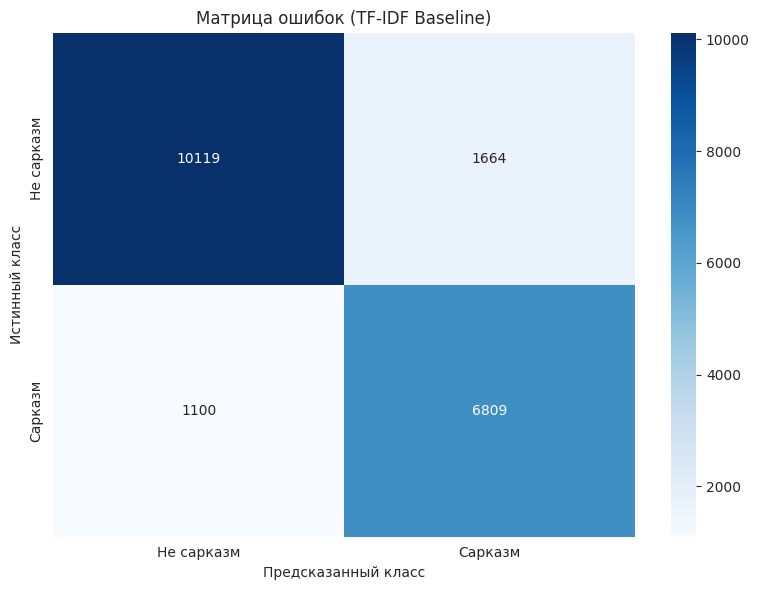


Интерпретация матрицы ошибок:
True Negatives (правильно определили не-сарказм): 10119
False Positives (ошибочно определили как сарказм): 1664
False Negatives (пропустили сарказм): 1100
True Positives (правильно определили сарказм): 6809


In [ ]:
cm = confusion_matrix(y_test, y_pred_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сарказм', 'Сарказм'],
            yticklabels=['Не сарказм', 'Сарказм'])
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок (TF-IDF Baseline)')
plt.tight_layout()
plt.show()

# Интерпретация матрицы ошибок
print("\nИнтерпретация матрицы ошибок:")
print(f"True Negatives (правильно определили не-сарказм): {cm[0, 0]}")
print(f"False Positives (ошибочно определили как сарказм): {cm[0, 1]}")
print(f"False Negatives (пропустили сарказм): {cm[1, 0]}")
print(f"True Positives (правильно определили сарказм): {cm[1, 1]}")

> Ваши выводы подтвердились?

Давайте посмотрим, какие слова модель считает наиболее важными для определения сарказма

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Топ слов, указывающих на сарказм (положительные коэффициенты)
top_sarcasm_indices = np.argsort(coefficients)[-20:]
top_sarcasm_words = [(feature_names[i], coefficients[i]) for i in top_sarcasm_indices]

# Топ слов, указывающих на отсутствие сарказма (отрицательные коэффициенты)
top_normal_indices = np.argsort(coefficients)[:20]
top_normal_words = [(feature_names[i], coefficients[i]) for i in top_normal_indices]

print("=" * 60)
print("ТОП-20 ПРИЗНАКОВ, УКАЗЫВАЮЩИХ НА САРКАЗМ:")
print("=" * 60)
for word, coef in reversed(top_sarcasm_words):
    print(f"{word:30s} {coef:8.4f}")

print("\n" + "=" * 60)
print("ТОП-20 ПРИЗНАКОВ, УКАЗЫВАЮЩИХ НА ОБЫЧНЫЙ ЗАГОЛОВОК:")
print("=" * 60)
for word, coef in top_normal_words:
    print(f"{word:30s} {coef:8.4f}")

ТОП-20 ПРИЗНАКОВ, УКАЗЫВАЮЩИХ НА САРКАЗМ:
nation                           5.7645
area                             5.2220
man                              5.1605
report                           4.8721
announces                        3.7359
local                            3.6648
study                            3.0708
fucking                          3.0599
clearly                          3.0065
introduces                       2.8684
bush                             2.8387
guy                              2.7711
shit                             2.7673
god                              2.5923
friend                           2.5543
fuck                             2.5295
hoping                           2.4344
entire                           2.4338
employee                         2.3946
excited                          2.3441

ТОП-20 ПРИЗНАКОВ, УКАЗЫВАЮЩИХ НА ОБЫЧНЫЙ ЗАГОЛОВОК:
trump                           -4.3747
says                            -3.4735
donald                   

Пупупу...

Сохраним результаты для последующего сравнения с другими методами

In [ ]:
# Создаем словарь с результатами baseline
baseline_results = {
    'model': 'TF-IDF + LogReg',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

# Создаем DataFrame для отслеживания всех результатов
results_comparison = pd.DataFrame([baseline_results])

print("Baseline модель готова! Результаты сохранены для сравнения.")
print(results_comparison)

Baseline модель готова! Результаты сохранены для сравнения.
             model  accuracy  precision    recall        f1
0  TF-IDF + LogReg  0.859638   0.803611  0.860918  0.831278


## Глава 2: Контекстуальные эмбеддинги

**Контекстуальные эмбеддинги** создают разные векторы для одного и того же слова в зависимости от контекста.

Это достигается благодаря архитектуре трансформеров (Transformers), которые анализируют все слова в предложении одновременно.

**Архитектура трансформеров**

Трансформер смотрит на все слова в предложении и определяет, какие слова важны для понимания каждого конкретного слова. Это называется механизм внимания (attention)!

*Про то, как работает механизм внимания хорошо объяснено* [*здесь*](https://habr.com/ru/articles/486358/)

А еще я здесь 3 часа могу рассказывать про [вот эту статью](https://arxiv.org/abs/1706.03762), но я не буду заставлять вас это слушать, но вы можете прочитать про это по-русски [здесь](https://habr.com/ru/articles/781770/)

**Очень кратко о том, как работает трансформер**

Основные компоненты:
- **Self-attention**: вычисляет веса взаимосвязей между всеми позициями входной последовательности, позволяя модели «фокусироваться» на релевантных частях.
- **Позиционное кодирование**: добавляется к входу, чтобы сохранить информацию о порядке слов (поскольку трансформер не имеет встроенной последовательности).
- **Encoder-Decoder структура**:  
  - *Encoder* — преобразует вход в скрытое представление,  
  - *Decoder* — генерирует выход пошагово, используя self-attention и attention к encoder-выходу.

### BERT: Bidirectional Encoder Representations from Transformers

**BERT** — это предобученная модель-трансформер от Google (2018 год).

**Ключевые особенности:**
- **Bidirectional** (двунаправленный): смотрит на контекст слева И справа *одновременно* (это же восторг!!!!)
- **Предобучен** на огромном корпусе текстов (Wikipedia + BookCorpus)
- **Fine-tuning**: можно дообучить на своей задаче

![IMG](https://camo.githubusercontent.com/5307970f5215af4f3433936bea08837ca46bdf7d609f4aa2bd87a264e87624dd/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f333030302f312a6a395239493474615735503471786143572d376c69772e706e67)

Специальные токены:

- [CLS] (classification): специальный токен в начале, его вектор используется для классификации
- [SEP] (separator): разделяет предложения

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

print("Загрузка BERT модели и токенизатора...") # это может занять некоторое время при первом запуске

# Загружаем предобученный BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

print("✓ BERT загружен!")
print(f"Размер словаря: {tokenizer.vocab_size}")
print(f"Максимальная длина последовательности: {tokenizer.model_max_length}")

Загрузка BERT модели и токенизатора...
✓ BERT загружен!
Размер словаря: 30522
Максимальная длина последовательности: 512


А откуда мы взяли эту модель? Тут семинар плавно переезжает [сюда...](https://huggingface.co/models)

Давайте посмотрим, как BERT разбивает текст на токены

In [ ]:
# Пример токенизации
example_text = "I hate school!"

print("Исходный текст:")
print(f"'{example_text}'")
print("\n" + "=" * 60)

# Токенизация
tokens = tokenizer.tokenize(example_text)
print("Токены:")
print(tokens)

# Преобразование в ID
token_ids = tokenizer.encode(example_text, add_special_tokens=True)
print(f"\nToken IDs (с [CLS] и [SEP]):")
print(token_ids)

# Декодирование обратно
decoded_text = tokenizer.decode(token_ids)
print(f"\nДекодированный текст:")
print(f"'{decoded_text}'")

# Визуализация специальных токенов
print("\n" + "=" * 60)
print("Структура входа в BERT:")
print("=" * 60)
all_tokens = tokenizer.convert_ids_to_tokens(token_ids)
for i, (token, token_id) in enumerate(zip(all_tokens, token_ids)):
    special = "  ← специальный токен" if token in ['[CLS]', '[SEP]'] else ""
    print(f"Позиция {i}: {token:15s} (ID: {token_id:5d}){special}")

Исходный текст:
'I hate school!'

Токены:
['i', 'hate', 'school', '!']

Token IDs (с [CLS] и [SEP]):
[101, 1045, 5223, 2082, 999, 102]

Декодированный текст:
'[CLS] i hate school! [SEP]'

Структура входа в BERT:
Позиция 0: [CLS]           (ID:   101)  ← специальный токен
Позиция 1: i               (ID:  1045)
Позиция 2: hate            (ID:  5223)
Позиция 3: school          (ID:  2082)
Позиция 4: !               (ID:   999)
Позиция 5: [SEP]           (ID:   102)  ← специальный токен


А вот [здесь](https://tiktokenizer.vercel.app) можно посмотреть на это онлайн!

Про токенизацию нам полезно понимать и тогда, когда мы работаем с ЛЛМ - потому что оплачиваем мы именно обработанное количество токенов.

Попробуйте позабивать туда короткую фразу ловеркейсом; апперкейсом; поставьте внутрь пробелы; напишите ее лЕсЕнКоЙ. Попробуйте то же самое для русской фразы.

Какие особенности токенизации ЛЛМ вы можете выявить на основе этих экспериментов?

### BERT и эмбеддинги

BERT может работать в двух режимах:

1. Feature extraction (извлечение признаков): используем предобученную модель без изменений
2. Fine-tuning (дообучение): дообучаем веса модели под нашу задачу

Начнем с первого подхода.

In [ ]:
# Функция для извлечения эмбеддингов из BERT
def get_bert_embeddings(texts, tokenizer, model, max_length=128):
    """
    Извлекает эмбеддинги BERT для списка текстов.
    Использует [CLS] токен как представление всего текста.
    """
    embeddings = []

    # Переводим модель в режим оценки (отключаем dropout)
    model.eval()

    # Отключаем вычисление градиентов для ускорения
    with torch.no_grad():
        for text in texts:
            # Токенизация с padding и truncation
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Получаем выход модели
            outputs = model(**encoded)

            # Берем вектор [CLS] токена (первый токен)
            # outputs.last_hidden_state имеет размер [batch_size, sequence_length, hidden_size]
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()

            embeddings.append(cls_embedding.numpy())

    return np.array(embeddings)

Получаем эмбеддинг для одного предложения

In [ ]:
example_sentence = "This is absolutely the best news ever!"

print(f"Получаем эмбеддинг для: '{example_sentence}'")

embedding = get_bert_embeddings([example_sentence], tokenizer, model)

print(f"\nРазмерность эмбеддинга: {embedding.shape}")
print(f"Первые 10 значений эмбеддинга:")
print(embedding[0][:10])

Получаем эмбеддинг для: 'This is absolutely the best news ever!'

Размерность эмбеддинга: (1, 768)
Первые 10 значений эмбеддинга:
[ 0.07193636  0.37352186  0.15202615 -0.24275564 -0.3509442  -0.80888677
  0.4630536   0.7464119   0.0304318  -0.28550774]


Давайте убедимся, что BERT действительно учитывает контекст!

In [ ]:
# Два предложения со словом "bank"
sentence1 = "I deposited money at the bank"
sentence2 = "We sat on the bank of the river"

# Получаем эмбеддинги
emb1 = get_bert_embeddings([sentence1], tokenizer, model)[0]
emb2 = get_bert_embeddings([sentence2], tokenizer, model)[0]

In [ ]:
# Вычисляем косинусное сходство
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity([emb1], [emb2])[0][0]

print("Сравнение эмбеддингов предложений с разным значением слова 'bank':")
print("=" * 70)
print(f"Предложение 1: {sentence1}")
print(f"Предложение 2: {sentence2}")
print(f"\nКосинусное сходство: {similarity:.4f}")
print("=" * 70)

Сравнение эмбеддингов предложений с разным значением слова 'bank':
Предложение 1: I deposited money at the bank
Предложение 2: We sat on the bank of the river

Косинусное сходство: 0.8584


In [ ]:
# Для сравнения: похожие предложения
sentence3 = "I saved money at the bank"
emb3 = get_bert_embeddings([sentence3], tokenizer, model)[0]
similarity_similar = cosine_similarity([emb1], [emb3])[0][0]

print(f"\nДля сравнения:")
print(f"Предложение 1: {sentence1}")
print(f"Предложение 3: {sentence3}")
print(f"Косинусное сходство: {similarity_similar:.4f}")


Для сравнения:
Предложение 1: I deposited money at the bank
Предложение 3: I saved money at the bank
Косинусное сходство: 0.9864


BERT понимает, что первое и третье предложение более похожи! Вау!

### Извлечение эмбеддингов для нашего датасета

Теперь применим BERT к нашему датасету новостных заголовков.

**Важно**: Обработка большого датасета может занять время. Для ускорения мы будем обрабатывать данные батчами.

In [ ]:
from tqdm import tqdm

def get_bert_embeddings_batched(texts, tokenizer, model, batch_size=32, max_length=128):
    """
    Извлекает эмбеддинги BERT для списка текстов при помощи батчей.
    """
    embeddings = []
    model.eval()

    # Разбиваем на батчи
    num_batches = (len(texts) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), total=num_batches, desc="Извлечение эмбеддингов"):
            batch_texts = texts[i:i + batch_size]

            # Токенизация батча
            encoded = tokenizer.batch_encode_plus(
                batch_texts,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Получаем выход модели
            outputs = model(**encoded)

            # Берем векторы [CLS] токена
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(cls_embeddings)

    return np.array(embeddings)

In [ ]:
# Извлекаем эмбеддинги BERT для train и test
print("Извлечение BERT эмбеддингов для обучающей выборки...")
X_train_bert = get_bert_embeddings_batched(
    X_train.tolist(),
    tokenizer,
    model,
    batch_size=32
)

print("\nИзвлечение BERT эмбеддингов для тестовой выборки...")
X_test_bert = get_bert_embeddings_batched(
    X_test.tolist(),
    tokenizer,
    model,
    batch_size=32
)

print("Эмбеддинги извлечены!")

Извлечение BERT эмбеддингов для обучающей выборки...


Извлечение эмбеддингов: 100%|██████████| 648/648 [34:38<00:00,  3.21s/it]



Извлечение BERT эмбеддингов для тестовой выборки...


Извлечение эмбеддингов: 100%|██████████| 616/616 [30:21<00:00,  2.96s/it]

Эмбеддинги извлечены!


In [ ]:
print(f"Форма train: {X_train_bert.shape}")
print(f"Форма test: {X_test_bert.shape}")

Форма train: (20721, 768)
Форма test: (19692, 768)


Теперь используем эмбеддинги BERT как признаки для логистической регрессии

In [ ]:
bert_classifier = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
bert_classifier.fit(X_train_bert, y_train)

print("Модель обучена!")

Модель обучена!


In [ ]:
y_pred_bert = bert_classifier.predict(X_test_bert)

print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11783
           1       0.86      0.86      0.86      7909

    accuracy                           0.88     19692
   macro avg       0.88      0.88      0.88     19692
weighted avg       0.88      0.88      0.88     19692



И, конечно же, куда мы без матрицы ошибок!

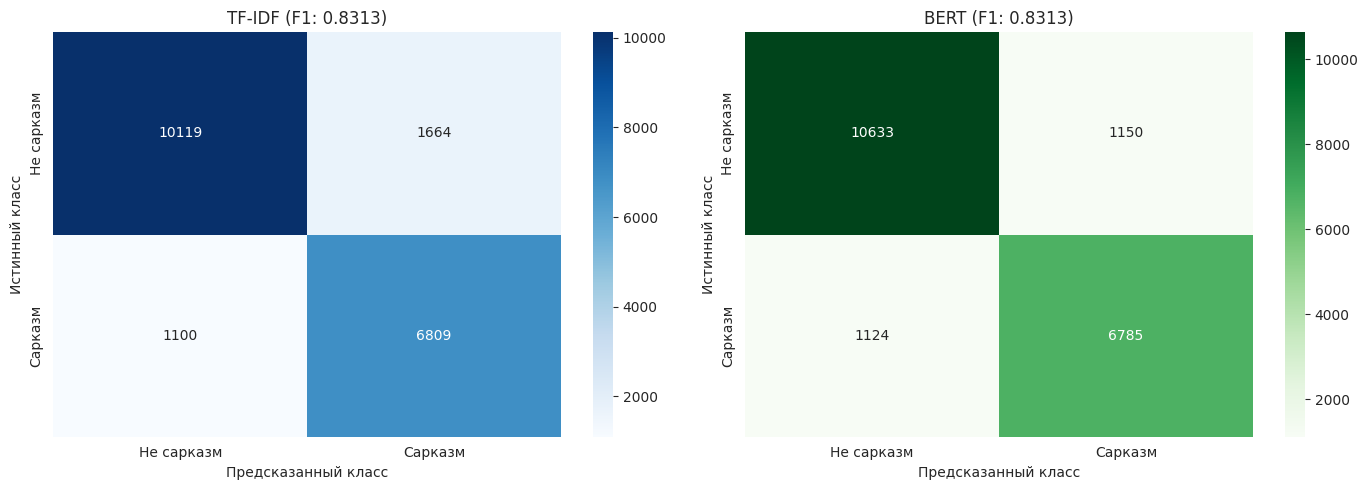

In [ ]:
cm_bert = confusion_matrix(y_test, y_pred_bert)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TF-IDF
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Не сарказм', 'Сарказм'],
            yticklabels=['Не сарказм', 'Сарказм'])
axes[0].set_ylabel('Истинный класс')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_title(f'TF-IDF (F1: {f1:.4f})')

# BERT
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Не сарказм', 'Сарказм'],
            yticklabels=['Не сарказм', 'Сарказм'])
axes[1].set_ylabel('Истинный класс')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_title(f'BERT (F1: {f1:.4f})')

plt.tight_layout()
plt.show()

> Сравните результаты с baseline. Какие выводы вы можете сделать?

### Fine-tuning BERT

До этого мы использовали BERT как экстрактор признаков — просто брали эмбеддинги и обучали классификатор сверху.

Можно попробовать fine-tuning — дообучить сами веса BERT под нашу задачу детекции сарказма!

Преимущества fine-tuning:

- Модель адаптируется под специфику задачи
- Обычно дает лучшее качество
- Но требует **больше вычислительных ресурсов**

Это займет слишком много времени семинара, а также ваших вычислительных ресурсов, потому что это ОЧЕНЬ продвинутая задача.

Если кому-то все же интересно, то можно посмотреть [здесь](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), а также написать мне, я постараюсь объяснить!)

### RoBERTa

**RoBERTa** (Robustly optimized BERT approach) — это улучшенная версия BERT.

Ключевые отличия от BERT:

- *Больше данных*: обучен на 160GB текста (BERT — 16GB)
- *Динамическое маскирование*: паттерн маскирования меняется на каждой эпохе
- *Больше батчи и больше шагов*: обучение дольше и с большими батчами
- *BPE токенизация*: более эффективная, чем WordPiece в BERT

RoBERTa **обычно** показывает лучшее качество, чем BERT!

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

print("RoBERTa загружен!")
print(f"Размер словаря: {roberta_tokenizer.vocab_size}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa загружен!
Размер словаря: 50265


In [ ]:
# Сравнение токенизации BERT vs RoBERTa

example = "I hate school!"

print("Исходный текст:")
print(f"'{example}'")
print("\n" + "=" * 60)

# BERT
bert_tokens = tokenizer.tokenize(example)
print("BERT токены:")
print(bert_tokens)
print(f"Количество токенов: {len(bert_tokens)}")

print("\n" + "=" * 60)

# RoBERTa
roberta_tokens = roberta_tokenizer.tokenize(example)
print("RoBERTa токены:")
print(roberta_tokens)
print(f"Количество токенов: {len(roberta_tokens)}")

Исходный текст:
'I hate school!'

BERT токены:
['i', 'hate', 'school', '!']
Количество токенов: 4

RoBERTa токены:
['I', 'Ġhate', 'Ġschool', '!']
Количество токенов: 4


RoBERTa использует BPE (Byte-Pair Encoding), что часто дает меньше токенов

Процесс извлечения эмбеддингов RoBERTa аналогичен BERT. Мы не будем останавливаться на этой модели слишком подробно, но вам важно про нее знать! Как минимум, если вы захотите использовать BERT-based модели в проекте, присмотритесь и к RoBERTa

### Визуализация эмбеддингов с t-SNE

In [ ]:
from sklearn.manifold import TSNE

# Берем подвыборку для визуализации
vis_size = 500
vis_indices = np.random.choice(len(X_test), vis_size, replace=False)

X_test_tfidf_vis = X_test_tfidf[vis_indices].toarray()
X_test_bert_vis = X_test_bert[vis_indices]
y_test_vis = y_test[vis_indices]

In [ ]:
# t-SNE для каждого типа эмбеддингов
# это может занять несколько минут
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

print("\nTF-IDF...")
X_tfidf_2d = tsne.fit_transform(X_test_tfidf_vis)

print("BERT...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_bert_2d = tsne.fit_transform(X_test_bert_vis)

print("t-SNE завершен!")


TF-IDF...
BERT...
t-SNE завершен!


## Глава 3: Другие техники создания эмбеддингов

Что, если нам нужно:

- Найти семантически похожие заголовки?
- Построить поисковую систему по новостям?
- Кластеризовать документы по темам?


Для таких задач существуют специализированные модели — `Sentence-Transformers`!

Проблема обычного BERT:

- BERT обучен на Masked Language Modeling (MLM) и Next Sentence Prediction (NSP). Эти задачи не оптимизированы для сравнения предложений
- Косинусное сходство между эмбеддингами BERT работает, но не идеально

Sentence Transformers (SBERT)

- Специально обучены для задач семантического сходства
- Эмбеддинги оптимизированы так, чтобы похожие предложения были близко в пространстве

**Sentence Transformers** — это модификация BERT/RoBERTa, обученная специально для получения качественных эмбеддингов **целых предложений**.

**Как они обучаются:**

1. **Siamese Network (Сиамская сеть)**
   - Берутся пары предложений: похожие и непохожие
   - Обе проходят через одну и ту же модель BERT
   - Модель учится делать похожие предложения близкими, а разные — далекими

```
Предложение 1: "I love pizza"  →  [BERT]  →  embedding₁
                                              ↓ (близко)
Предложение 2: "Pizza is great" →  [BERT]  →  embedding₂

Предложение 3: "The weather is bad" → [BERT] → embedding₃ (далеко от 1 и 2)
```

2. **Triplet Loss**
   - Используются триплеты: (anchor, positive, negative)
   - Anchor и positive должны быть близко
   - Anchor и negative должны быть далеко

**Популярные [модели Sentence Transformers](https://huggingface.co/sentence-transformers):**
- `all-MiniLM-L6-v2` — быстрая и качественная (384 размерности)
- `all-mpnet-base-v2` — более мощная (768 размерностей)
- `paraphrase-multilingual-MiniLM-L12-v2` — мультиязычная

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# Загружаем несколько моделей Sentence Transformers

# Компактная и быстрая модель
sbert_mini = SentenceTransformer('all-MiniLM-L6-v2')
print("all-MiniLM-L6-v2 загружена")
print(f"Размерность эмбеддингов: {sbert_mini.get_sentence_embedding_dimension()}")

# Более мощная модель
sbert_mpnet = SentenceTransformer('all-mpnet-base-v2')
print("all-mpnet-base-v2 загружена")
print(f"Размерность эмбеддингов: {sbert_mpnet.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

all-MiniLM-L6-v2 загружена
Размерность эмбеддингов: 384


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

all-mpnet-base-v2 загружена
Размерность эмбеддингов: 768


Давайте посмотрим, как Sentence Transformers понимают семантику!

In [ ]:
sentences = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "Someone in a gorilla costume is playing a set of drums."
]

print("Исходные предложения:")
print("=" * 70)
for i, sent in enumerate(sentences):
    print(f"{i}: {sent}")

Исходные предложения:
0: A man is eating food.
1: A man is eating a piece of bread.
2: The girl is carrying a baby.
3: A man is riding a horse.
4: A woman is playing violin.
5: Two men pushed carts through the woods.
6: A man is riding a white horse on an enclosed ground.
7: A monkey is playing drums.
8: Someone in a gorilla costume is playing a set of drums.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Получаем эмбеддинги
embeddings = sbert_mini.encode(sentences, convert_to_tensor=True)

print(f"\nФорма эмбеддингов: {embeddings.shape}")
print(f"(9 предложений × {sbert_mini.get_sentence_embedding_dimension()} размерностей)")

# Вычисляем матрицу косинусного сходства
cosine_scores = cosine_similarity(embeddings, embeddings)

print("\nМатрица косинусного сходства:")
print("=" * 70)

# Выводим матрицу сходства
print("\n      ", end="")
for i in range(len(sentences)):
    print(f"  {i}  ", end="")
print()

for i in range(len(sentences)):
    print(f"  {i}:  ", end="")
    for j in range(len(sentences)):
        score = cosine_scores[i][j].item()
        print(f"{score:.2f} ", end="")
    print()


Форма эмбеддингов: torch.Size([9, 384])
(9 предложений × 384 размерностей)

Матрица косинусного сходства:

        0    1    2    3    4    5    6    7    8  
  0:  1.00 0.76 -0.10 0.25 -0.07 -0.03 0.17 0.05 0.06 
  1:  0.76 1.00 -0.06 0.14 -0.08 -0.02 0.12 0.04 0.02 
  2:  -0.10 -0.06 1.00 -0.11 0.02 -0.04 -0.09 0.02 0.02 
  3:  0.25 0.14 -0.11 1.00 -0.03 0.04 0.74 0.08 0.14 
  4:  -0.07 -0.08 0.02 -0.03 1.00 -0.17 -0.06 0.20 0.26 
  5:  -0.03 -0.02 -0.04 0.04 -0.17 1.00 0.08 -0.04 -0.09 
  6:  0.17 0.12 -0.09 0.74 -0.06 0.08 1.00 0.05 0.12 
  7:  0.05 0.04 0.02 0.08 0.20 -0.04 0.05 1.00 0.64 
  8:  0.06 0.02 0.02 0.14 0.26 -0.09 0.12 0.64 1.00 


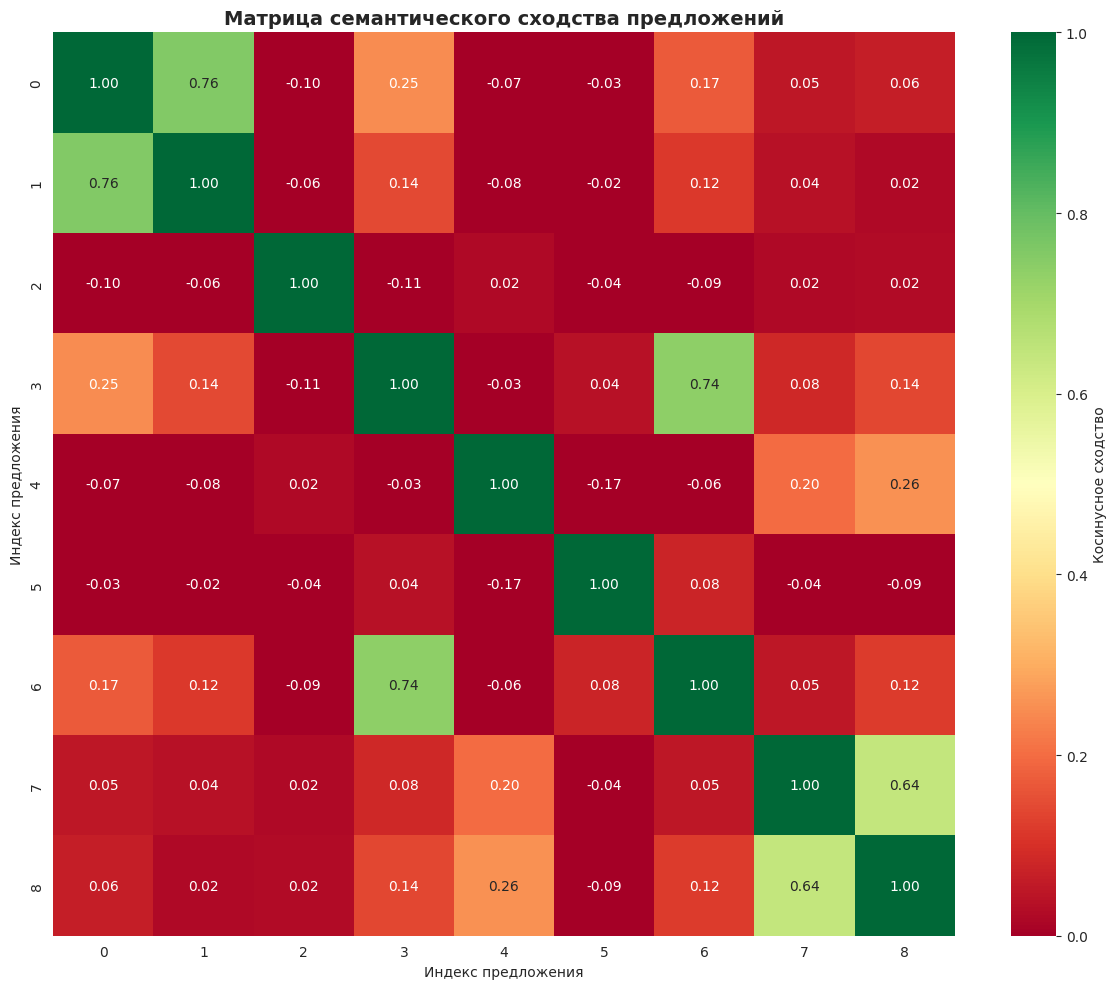


Обратите внимание:
• Предложения 0 и 1 (оба про еду) имеют высокое сходство
• Предложения 7 и 8 (оба про игру на барабанах) очень похожи
• Предложения 3 и 6 (оба про лошадь) похожи


In [ ]:
# Визуализация матрицы сходства

plt.figure(figsize=(12, 10))
sns.heatmap(cosine_scores,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn',
            xticklabels=range(len(sentences)),
            yticklabels=range(len(sentences)),
            vmin=0, vmax=1,
            cbar_kws={'label': 'Косинусное сходство'})
plt.title('Матрица семантического сходства предложений', fontsize=14, fontweight='bold')
plt.xlabel('Индекс предложения')
plt.ylabel('Индекс предложения')
plt.tight_layout()
plt.show()

print("\nОбратите внимание:")
print("• Предложения 0 и 1 (оба про еду) имеют высокое сходство")
print("• Предложения 7 и 8 (оба про игру на барабанах) очень похожи")
print("• Предложения 3 и 6 (оба про лошадь) похожи")

Теперь применим Sentence Transformers к нашим данным!

In [ ]:
# Используем show_progress_bar для отображения прогресса
X_train_sbert = sbert_mini.encode(
    X_train.tolist(),
    show_progress_bar=True,
    batch_size=64,
    convert_to_numpy=True
)

X_test_sbert = sbert_mini.encode(
    X_test.tolist(),
    show_progress_bar=True,
    batch_size=64,
    convert_to_numpy=True
)

print(f"\nЭмбеддинги извлечены!")
print(f"Форма train: {X_train_sbert.shape}")
print(f"Форма test: {X_test_sbert.shape}")

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

Batches:   0%|          | 0/308 [00:00<?, ?it/s]


Эмбеддинги извлечены!
Форма train: (20721, 384)
Форма test: (19692, 384)


In [ ]:
# Обучение классификатора на SBERT эмбеддингах

sbert_classifier = LogisticRegression(max_iter=5000, random_state=42, n_jobs=-1)
sbert_classifier.fit(X_train_sbert, y_train)

print("Модель обучена!")

Модель обучена!


In [ ]:
# Предсказания
y_pred_sbert = sbert_classifier.predict(X_test_sbert)

print(classification_report(y_test, y_pred_sbert))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     11783
           1       0.77      0.74      0.75      7909

    accuracy                           0.80     19692
   macro avg       0.80      0.79      0.80     19692
weighted avg       0.80      0.80      0.80     19692



> Ну как вам?)

Одно из главных преимуществ Sentence Transformers — возможность **семантического поиска**!

Задача: По запросу найти самые похожие заголовки из датасета.

In [ ]:
# Создаем функцию для семантического поиска

def semantic_search(query, corpus_embeddings, corpus_texts, top_k=5):
    """
    Выполняет семантический поиск по корпусу текстов.

    Args:
        query: текст запроса
        corpus_embeddings: эмбеддинги всех текстов в корпусе
        corpus_texts: сами тексты
        top_k: количество результатов

    Returns:
        список кортежей (текст, score)
    """
    # Получаем эмбеддинг запроса
    query_embedding = sbert_mini.encode(query, convert_to_tensor=True)

    # Вычисляем сходство со всеми текстами
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

    # Находим топ-k
    top_results = torch.topk(cos_scores, k=min(top_k, len(corpus_texts)))

    results = []
    for score, idx in zip(top_results[0], top_results[1]):
        results.append((corpus_texts[idx], score.item()))

    return results

In [ ]:
# Получаем эмбеддинги всего тестового набора (если еще не получили)
test_corpus_embeddings = torch.tensor(X_test_sbert)

print("Давайте попробуем семантический поиск!")
print("=" * 80)

# Поиск заголовков про политику. Вы можете подставить любой заголовок, который вам хочется
query = "political scandal and corruption"

print(f"\nЗапрос: '{query}'")
print("-" * 80)

results1 = semantic_search(query, test_corpus_embeddings, X_test, top_k=5)
for i, (text, score) in enumerate(results1, 1):
    label = "САРКАЗМ" if y_test[np.where(X_test == text)[0][0]] == 1 else "НОВОСТЬ"
    print(f"\n{i}. Сходство: {score:.4f} | {label}")
    print(f"   {text}")

Давайте попробуем семантический поиск!

Запрос: 'political scandal and corruption'
--------------------------------------------------------------------------------


NameError: name 'util' is not defined

## Выводы

### Сравнительная таблица всех методов

| Метод | Размерность | Скорость | Качество | Плюсы | Минусы | Когда использовать |
|-------|-------------|----------|----------|-------|--------|-------------------|
| **TF-IDF** | ~5000-10000 (разреженная) | ⚡⚡⚡⚡⚡ Очень быстро | ⭐⭐⭐ Средне | • Простота<br>• Интерпретируемость<br>• Не требует GPU<br>• Малый размер модели | • Не понимает семантику<br>• Не учитывает порядок слов<br>• Высокая размерность<br>• Плохо с синонимами | Быстрый baseline, простые задачи классификации, когда важна интерпретируемость |
| **BERT<br>(feature extraction)** | 768 (плотная) | ⚡⚡⚡ Средне | ⭐⭐⭐⭐ Хорошо | • Понимает контекст<br>• Улавливает семантику<br>• Компактные векторы<br>• Не требует дообучения | • Медленнее TF-IDF<br>• Требует GPU для скорости<br>• Большая модель (110M параметров)<br>• Не оптимизирован для сравнения текстов | Когда нужно качество выше baseline, но нет ресурсов на fine-tuning |
| **BERT<br>(fine-tuned)** | 768 + голова классификации | ⚡⚡ Медленное обучение<br>⚡⚡⚡⚡ Быстрый inference | ⭐⭐⭐⭐⭐ Отлично | • Максимальное качество<br>• Адаптируется под задачу<br>• Понимает специфику данных<br>• End-to-end обучение | • Требует много данных<br>• Долгое обучение<br>• Нужен GPU<br>• Риск переобучения<br>• Сложнее в deployment | Когда нужно максимальное качество, есть достаточно данных и вычислительные ресурсы |
| **RoBERTa<br>(feature extraction)** | 768 (плотная) | ⚡⚡⚡ Средне | ⭐⭐⭐⭐ Очень хорошо | • Лучше BERT<br>• Более робастная<br>• Лучшая токенизация<br>• Обучена на большем объеме данных | • Те же что у BERT<br>• Немного медленнее BERT<br>• Модель чуть больше | Аналогично BERT, когда нужен небольшой прирост качества |
| **RoBERTa<br>(fine-tuned)** | 768 + голова классификации | ⚡⚡ Медленное обучение<br>⚡⚡⚡⚡ Быстрый inference | ⭐⭐⭐⭐⭐ Отлично+ | • Обычно лучше fine-tuned BERT<br>• Более стабильное обучение<br>• Все плюсы BERT | • Все минусы fine-tuned BERT<br>• Чуть дольше обучается | Когда нужен абсолютный максимум качества |
| **Sentence-BERT<br>(MiniLM)** | 384 (плотная) | ⚡⚡⚡⚡⚡ Очень быстро | ⭐⭐⭐⭐ Хорошо | • Быстрый<br>• Компактный<br>• Оптимизирован для сравнения<br>• Отличный semantic search<br>• Хорошая кластеризация | • Меньшая размерность<br>• Немного хуже для классификации чем BERT<br>• Не fine-tunable для специфичных задач | Semantic search, поиск похожих текстов, кластеризация, рекомендательные системы |
| **Sentence-BERT<br>(MPNet)** | 768 (плотная) | ⚡⚡⚡ Средне | ⭐⭐⭐⭐⭐ Отлично | • Лучшее качество среди SBERT<br>• Оптимизирован для similarity<br>• Универсальный<br>• Хорош и для классификации | • Медленнее MiniLM<br>• Больше памяти<br>• Все еще медленнее TF-IDF | Когда нужно и semantic search, и высокое качество классификации |

---

### Практические рекомендации

#### Выбор по задаче:

**1. Классификация текстов (sentiment, topic, spam)**
```
Быстрый прототип → TF-IDF
Хорошее качество → BERT/RoBERTa (feature extraction)
Максимум качества → BERT/RoBERTa (fine-tuned)
```

**2. Семантический поиск / поиск похожих документов**
```
Лучший выбор → Sentence-BERT (MiniLM или MPNet)
Альтернатива → BERT/RoBERTa с mean pooling
```

**3. Кластеризация документов**
```
Лучший выбор → Sentence-BERT
Альтернатива → TF-IDF (для больших корпусов)
```

**4. Question Answering / Chatbots**
```
Лучший выбор → Fine-tuned BERT/RoBERTa
Для поиска контекста → Sentence-BERT
```

**5. Рекомендательные системы**
```
Лучший выбор → Sentence-BERT
Для content-based → TF-IDF + Sentence-BERT
```

#### Выбор по ресурсам:

**Если у вас нет GPU:**
```
TF-IDF или Sentence-BERT (MiniLM) на CPU
```

**Если есть GPU, но мало данных (<1000 примеров):**
```
BERT/RoBERTa feature extraction + классификатор
```

**Если есть GPU и много данных (>10000 примеров):**
```
Fine-tuned BERT/RoBERTa
```

**Если нужна скорость в production:**
```
TF-IDF или Sentence-BERT (MiniLM)
Можно рассмотреть дистилляцию больших моделей
```

### 📚 Дополнительные ресурсы

**Для дальнейшего изучения:**
- Hugging Face Transformers: https://huggingface.co/transformers/
- Sentence Transformers: https://www.sbert.net/
- Papers with Code: https://paperswithcode.com/task/text-classification

**Предобученные модели:**
- Hugging Face Hub: https://huggingface.co/models
- Выбирайте модели по задаче и языку!

---

## Чем я пользовалась при подготовке или просто **Список Литературы**

1. [Что такое эмбеддинги и как с ними работать](https://habr.com/ru/articles/947216/)